In [1]:
!pip install keras
!pip install scikit-image
!pip install pillow

    100% |████████████████████████████████| 317kB 22kB/s ta 0:00:016
    100% |████████████████████████████████| 276kB 13kB/s ta 0:00:014
    100% |████████████████████████████████| 24.7MB 208kB/s ta 0:00:01   15% |█████                           | 3.8MB 217kB/s eta 0:01:37    22% |███████▏                        | 5.5MB 243kB/s eta 0:01:19    35% |███████████▌                    | 8.9MB 271kB/s eta 0:00:59    65% |█████████████████████           | 16.2MB 758kB/s eta 0:00:12    67% |█████████████████████▌          | 16.5MB 900kB/s eta 0:00:10    73% |███████████████████████▍        | 18.1MB 814kB/s eta 0:00:09    89% |████████████████████████████▋   | 22.1MB 556kB/s eta 0:00:05    94% |██████████████████████████████▏ | 23.2MB 329kB/s eta 0:00:05
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
    100% |████████████████████████████████| 26.2MB 264kB/s ta 0:00:01  3% |█▏                              | 92

In [2]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.4


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [3]:
# Traemos el modelo
inet_model = inc_net.InceptionV3()

W0412 13:47:08.303159 139673798633216 deprecation.py:237] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4139: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0412 13:47:08.428531 139673798633216 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/moving_averages.py:211: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


96116736/96112376 [==============================] - 212s 2us/step


In [4]:
# Funcion para transformar imagenes
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [5]:
# create the base pre-trained model
#pesos de imagenet
#Decapitando. Tope de softmax
base_model = inc_net.InceptionV3(weights='imagenet', include_top=False)


87916544/87910968 [==============================] - 107s 1us/step


In [6]:
from keras.layers import Dense, GlobalAveragePooling2D
# Agrega cabeza
# add a global spatial average pooling layer
x = base_model.output #Salida del modelo
x = GlobalAveragePooling2D()(x) #Pooling toma decisiones, promedio de la vecindad
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x) #Inception termina con 1024. Transformar 1024 entre una densa
# and a logistic layer -- let's say we have 4 classes
num_classes=2
predictions = Dense(num_classes, activation='softmax')(x) #Puedo haber sido Sigmoide
#20 imaga
#Predictions es salida

In [7]:
from keras.models import Model

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
index=0
for layer in base_model.layers:
    if index>293:
        layer.trainable = True #Modificar ultimas capas
    else:
        layer.trainable = False
    index=index+1

In [9]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0412 13:54:16.389670 139673798633216 deprecation.py:237] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [10]:
from keras.preprocessing.image import ImageDataGenerator #alimentar datos a la red. Las transforma y alimenta
from keras.applications.inception_v3 import preprocess_input
train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
#                               preprocessing_function=transform_img_fn)
                               preprocessing_function=preprocess_input) #Funcion que creamos al principio
train_gen = train_idg.flow_from_directory(
    'fotos/',
    target_size=(299, 299),
    batch_size = 16
)

Found 20 images belonging to 2 classes.


In [11]:
history = model.fit_generator(train_gen, 
                              epochs=2, 
                              #use_multiprocessing=True,
                              verbose=True,
                              steps_per_epoch=100)

Epoch 1/2
100/100 [==============================] - 213s 2s/step - loss: 0.4780 - acc: 0.8567
Epoch 2/2
100/100 [==============================] - 202s 2s/step - loss: 0.1475 - acc: 0.9553


### Guardar modelo

In [12]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
#Alimenta los orignaes
array =model.predict_generator(train_gen, 
                               steps=len(train_gen),
                              verbose=True)

2/2 [==============================] - 10s 5s/step


In [14]:
print([np.argmax(array[i]) for i in range(array.shape[0])])

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0


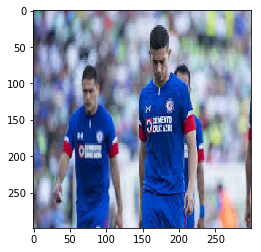

In [20]:
#out_100_101
images = transform_img_fn([os.path.join('fotos/cruz_azul','foto_ca_01.jpg')])
#images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = model.predict(images)
print(np.argmax(preds))

0


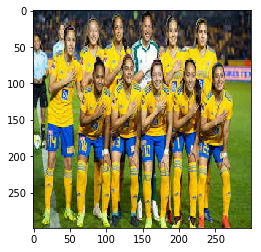

In [21]:
#out_100_101
images = transform_img_fn([os.path.join('fotos/tigres','foto_10.jpg')])
#images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = model.predict(images)
print(np.argmax(preds))

In [17]:
 # later...
from keras.models import model_from_json 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
%load_ext_autoreload
%auoteload 2
%import os, sys
try:
    import lime
except:
    sys.path.append(os.path.join("..",".."))
    import lime 

temp, mask = explnation.get_image_and_mask(0, positive_only = True, num_features = 5, hide_rest=True)
plt.imshow(mark_boundaries